## Statistical Learning For Healthcare Data - Final Project - Diabetes
Group members: Giovanni Mele, Elisa Broserà

This project aims to predict the **risk of hospital readmission for diabetic patients** using a large clinical dataset from U.S. hospitals.

The goal is to classify patients into three categories: not readmitted, readmitted within 30 days, or readmitted after 30 days of discharge.

The main steps will be: 
- **Dataset creation**
- **Data visualization**
- **Data preprocessing**
- **Model implementation**
- **Model fine-tuning**
- **Feature interpretation**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import PolynomialFeatures

# Dataset Creation
For the dataset creation step, we refer to the dedicated notebook "DatasetCreation.ipynb"

In [2]:
dataset_full = pd.read_csv("final_dataset_1")

In [3]:
dataset = dataset_full

# Data Visualization
A preliminary data visualization can be useful to framing the problem.



Some numerical variables show noticeable differences when analyzed with respect to the target label, while others appear relatively homogeneous regardless of the target.

C:\Users\giovi\AppData\Local\Temp\ipykernel_21140\2299449992.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted',y='time_in_hospital',data=dataset, palette='coolwarm', saturation=1.00)


<Axes: xlabel='readmitted', ylabel='time_in_hospital'>

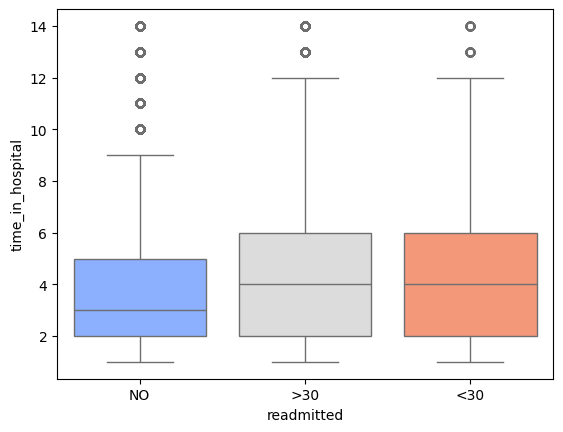

In [101]:
sns.boxplot(x='readmitted',y='time_in_hospital',data=dataset, palette='coolwarm', saturation=1.00)

C:\Users\giovi\AppData\Local\Temp\ipykernel_21140\2701787457.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted',y='n_treatments',data=dataset, palette='coolwarm', saturation=1.00)


<Axes: xlabel='readmitted', ylabel='n_treatments'>

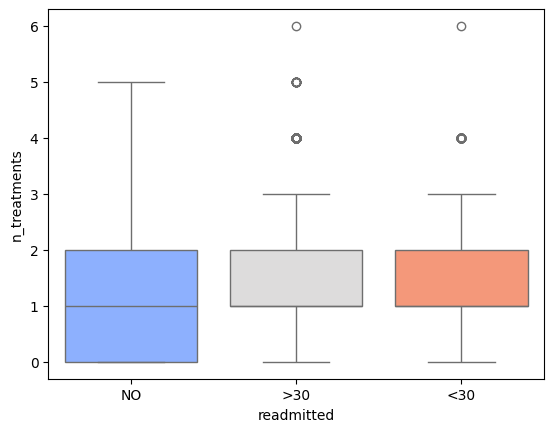

In [100]:
sns.boxplot(x='readmitted',y='n_treatments',data=dataset, palette='coolwarm', saturation=1.00)

C:\Users\giovi\AppData\Local\Temp\ipykernel_21140\2394464885.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted',y='num_lab_procedures',data=dataset, palette='coolwarm', saturation = 1)


<Axes: xlabel='readmitted', ylabel='num_lab_procedures'>

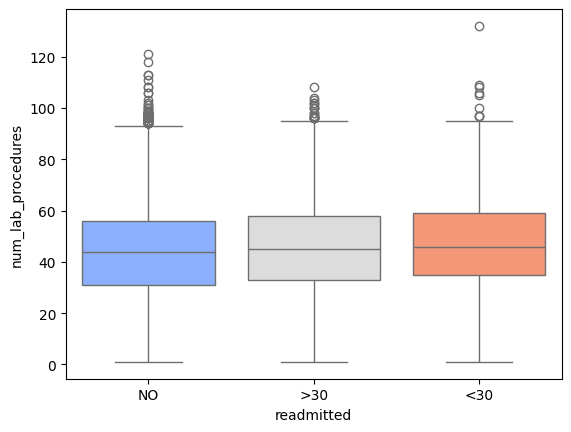

In [99]:
sns.boxplot(x='readmitted',y='num_lab_procedures',data=dataset, palette='coolwarm', saturation = 1)

The first feature, 'time_in_hospital', shows noticeably different distributions across target classes—especially in terms of their medians. The number of treatments seem to have different distributions across the dependent variable too.
The third feature, the number of laboratory procedures , by contrast, exhibits more homogeneous distributions across the classes.

### Correlation Analysis

We also analyze the potential correlations among the numerical variables and found no strong correlations, which leed us to retain all of them in the analysis.

The only notable observation concerns the number of medications, which shows some correlation with both the time spent in the hospital and the number of laboratory procedures. However, since the correlation coefficients are below 0.50, this relationship is not strong enough to justify the exclusion of any variable a priori.

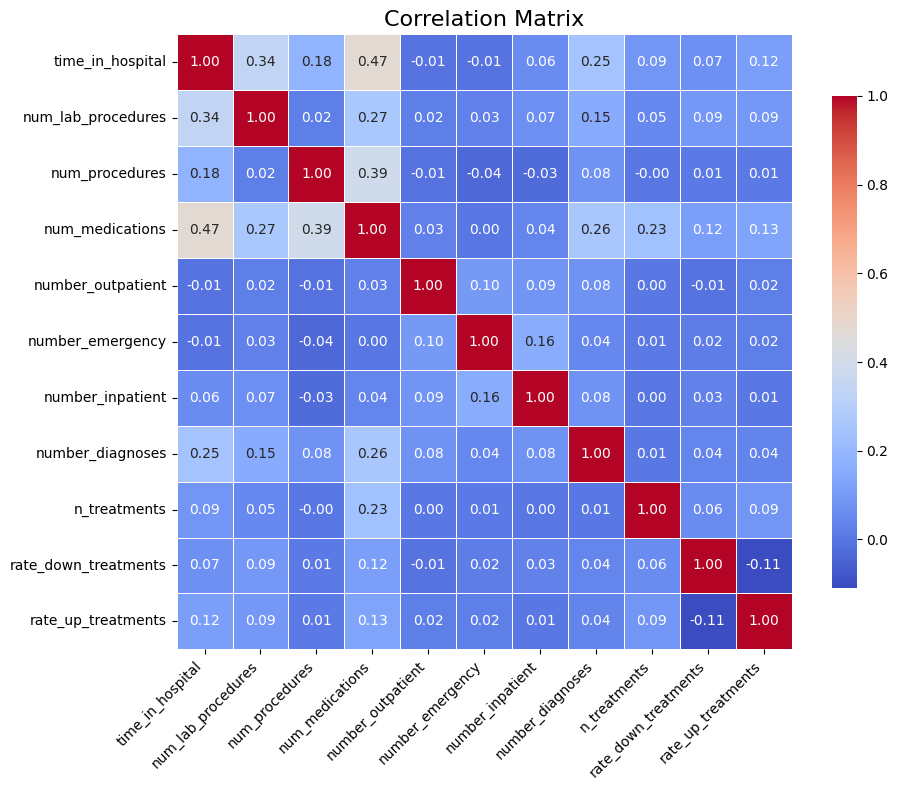

In [82]:
numeric_variables = dataset.select_dtypes(include='number')

corr_matrix = numeric_variables.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,        
            fmt=".2f",         
            cmap='coolwarm',   
            square=True,       
            cbar_kws={"shrink": 0.8},  
            linewidths=0.5,    
            linecolor='white')

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From a first look at the data we also identify a relevent problem: class imbalance for the target variable.

We will manage it below.

In [4]:
dataset.readmitted.value_counts()

readmitted
NO     33964
>30    18114
<30     5065
Name: count, dtype: int64

In [5]:
y = dataset['readmitted']

In [6]:
X = dataset.drop(columns = "readmitted", axis = 1)

# Data Preprocessing

### Training-Validation-Test split + Data Augmentation 
For each classification technique used, the approach id the same. The starting dataset is splitted between training and test set: this operation is performed as first one in order to obtain a test set that resembles the most to the real dataset.

Then, the training set is balanced using SMOTENC, i.e. the version of SMOTE for mixed datasets of both numerical and categorical variables.
So, model validation and hyperparameters tuning is done on the "balanced" training set (always performing 5 or 3 Fold Cross Validation) and the selected models are tested at the end to the test set.

Note that SMOTENC is applied only AFTER the train-test split to keep in the test set **only true data** and not generated ones.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15,stratify=y, random_state=42)

In [8]:
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

In [9]:
smote_nc = SMOTENC(categorical_features=categoric_columns, random_state=42)
X_SMOTENC, y_SMOTENC = smote_nc.fit_resample(X_train, y_train)

In [11]:
y_SMOTENC.value_counts()

readmitted
<30    28869
NO     28869
>30    28869
Name: count, dtype: int64

### Pipeline creation
For each model, we perform these preprocessing steps: 
- for numerical variables, we standardize them
- for categorical variables, we encode them with One Hot Encoding, because categories are not ordinal

We automize these steps using a pipeline composed of a ColumnTransformer preprocessor and the selected classifier.

In [12]:
preprocessor = ColumnTransformer([('num', StandardScaler(), numeric_columns),
                                  ('cat',OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns)])

# Model implementation
- Logistic Regression
- from Decision Trees to Random Forest
- AdaBoost 
- Ensemble method with majority voting

## Logistic Regression

The first model is a Multiclass (Softmax) Logistic Regression without regularization penalty.

In [13]:
pipeline_logistic = Pipeline([('preproc',preprocessor),
                     ('classifier', LogisticRegression(penalty=None,max_iter = 1000, multi_class='multinomial'))])

For completeness, it is important to explain why class imbalance is a problem that requires careful attention.

When a model is trained on an unbalanced dataset, it tends to learn a **"lazy" classification rule** — that is, it will classify most unseen instances as belonging to the majority class.

Moreover, it is important to emphasize that in such cases, accuracy is often not the most reliable metric. Relying solely on accuracy can be misleading, as it may give the false impression that the model is performing well, even when it fails to correctly identify the minority class.

**Accuracy** is also particularly inadequate when different types of misclassification carry **different costs** or consequences. For example, in our case, predicting that a patient will not be readmitted to the hospital when they actually will is a more severe error.

For this reason, the primary metric we use is the **weighted F1 score**, which better captures the balance between precision and recall across classes. Accuracy is reported only as a secondary metric.

In [14]:
pipeline_logistic.fit(X_train, y_train)

C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    penalty=None))])

In [15]:
y_pred_logistic = pipeline_logistic.predict(X_test)

### Unreliability of accuracy

In [ ]:
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_logistic

0.6046430237984134

In [17]:
cm_logistic_unbalanced = confusion_matrix(y_test, y_pred_logistic)

The model classifies most unseen instances as belonging to the majority class.

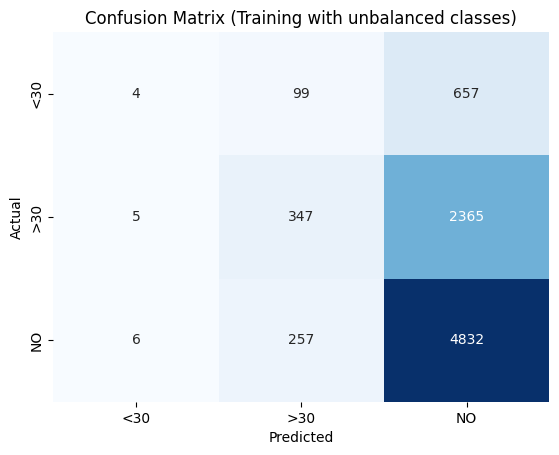

In [18]:
sns.heatmap(cm_logistic_unbalanced, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=pipeline_logistic.classes_, yticklabels=pipeline_logistic.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training with unbalanced classes)')
plt.show()

## Logistic Regression with augmented dataset (using SMOTENC)

Let's repeat the same steps again changing the metric and using the balanced dataset.


In [ ]:
f1_macro_validation = cross_val_score(pipeline_logistic, X_SMOTENC, y_SMOTENC, cv=5, scoring = 'f1_macro')


In [20]:
print(np.mean(f1_macro_validation))

0.49052912145892524


In [21]:
pipeline_logistic.fit(X_SMOTENC,y_SMOTENC)

C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    penalty=None))])

In [22]:
y_pred_logistic_SMOTENC = pipeline_logistic.predict(X_test)

In [23]:
cm_SMOTENC = confusion_matrix(y_test, y_pred_logistic_SMOTENC)

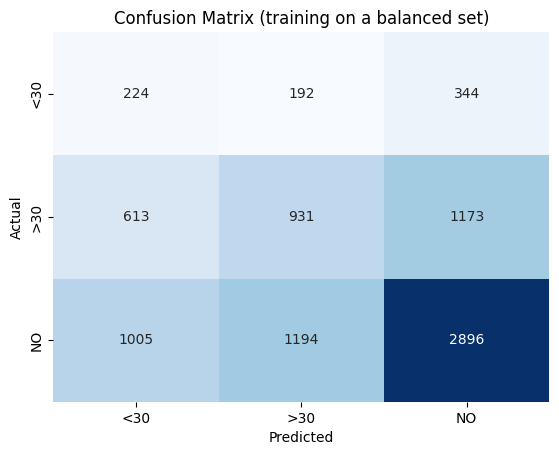

In [24]:
sns.heatmap(cm_SMOTENC, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=pipeline_logistic.classes_, yticklabels=pipeline_logistic.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (training on a balanced set)')
plt.show()

Note that for this part will be also used the F1 "macro" score, but only for graphical and validation purposes (because some tools in scikit-learn only have "f1_macro" as default). This is correct because the training set has been balanced before, and so using the weighted version of F1 score would lead to the same results.

In a multiclass problem, "F1_macro" is the mean of the F1 scores for each class, while the weighted takes into account the numerosity of each class.

In the testing phase, because we've decided to use a **stratified** test set  we will rely more on **weighted** f1 score, keeping also track for completeness of accuracy.

In [26]:
f1_logistic_weighted = f1_score(y_test, y_pred_logistic_SMOTENC, average='weighted')
f1_logistic_weighted

0.49458207349645644

In [ ]:
accuracy_logistic = accuracy_score(y_test, y_pred_logistic_SMOTENC)
accuracy_logistic

### Bias-Variance Analysis

In [27]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline_logistic,
    X=X_SMOTENC, y=y_SMOTENC,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='f1_macro'
)

C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2k

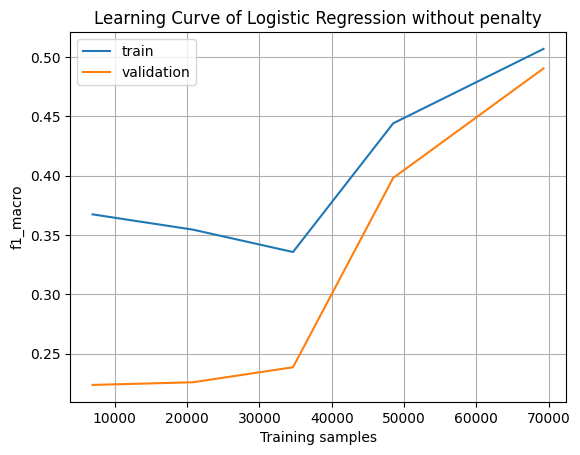

In [28]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("f1_macro")
plt.legend(); plt.grid()
plt.title("Learning Curve of Logistic Regression without penalty")
plt.show()


As the training size increases, the model improves its learning, evidenced by the validation score rising accordingly. Notably, from around 40,000 training observations onward, the model’s performance surpasses that of a **random choice model**.


Let's recall that Accuracy, Recall and Precision of a random classification model with $K=3$ classes are equal to $\frac{1}{K}$.

So, the f1_macro for a random classifier, which is the aritmetic mean of the $K$ f1 scores $F1_i$ related to each class with respect to the others, will be $$ F1_{i} = \frac{2 * Recall_i * Precision_i}{Recall_i + Precision_i} = \frac{2*\frac{1}{3}*\frac{1}{3}}{\frac{1}{3}+\frac{1}{3}} = \frac{1}{3}$$

Then, the mean of each score will be equal to $\frac{1}{3}$.

Looking at the validation and training performances with the maximum size of the training set used, we have performances on the training set which are only slightly higher than the ones on the validation set. 

This means that our model suffer from bias, and this could derived from multiple causes: 
- the chosen model could be too simple
- we could need more informative data in our input space


However, as we said, performances of the model are not too critical as they are consistently over the random choice performances.

So it can be meaningful a preliminary feature analysis of the model.

In particular, Logistic Recression offers an "integrated" feature selection approach, as it can be trained adding a penalization term in the loss function in order to limitate the norm of the parameters vector of the model.

One can perform both Ridge (L2) or Lasso (L1) regularization, but coherently to what we said before, in order to keep as much as possible information from the data, we will use Ridge regression.

In [29]:
pipeline_logistic.set_params(classifier__penalty = 'l2')

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [30]:
C_range = [10**exp for exp in [-5,-4,-3,-2,-1,0,1,2,3]]

In [31]:
train_scores, val_scores = validation_curve(
    pipeline_logistic, X_SMOTENC, y_SMOTENC,
    param_name="classifier__C", param_range=C_range,
    cv=5, scoring="f1_macro"
)


C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

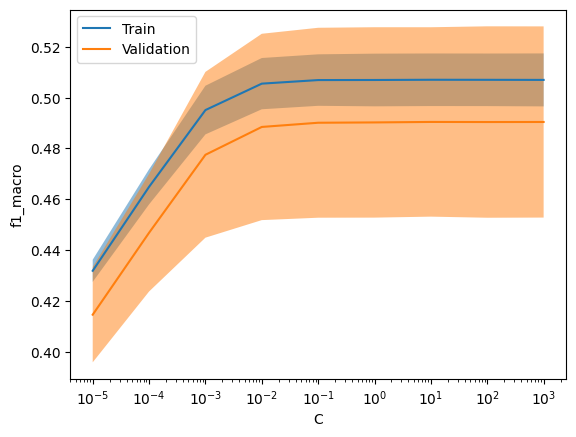

In [32]:
display = ValidationCurveDisplay(
    param_name="C", param_range=np.array(C_range),
    train_scores=train_scores, test_scores=val_scores, score_name="f1_macro"
)
display.plot()
plt.legend(['Train','Validation'])
plt.show()

A value of $C = 10^{-2}$ appears to offer a good **balance** for regularization, effectively penalizing complexity without sacrificing too much predictive information.

In [33]:
pipeline_logistic.set_params(classifier__C = 1e-2)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000,
                                    multi_class='multinomial'))])

In [34]:
pipeline_logistic.fit(X_SMOTENC,y_SMOTENC)

C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000,
                                    multi_class='multinomial'))])

In [ ]:
ohe = pipeline_logistic.named_steps['preproc'].named_transformers_['cat']
num_feats = numeric_columns
cat_feats = ohe.get_feature_names_out(categoric_columns)
feature_names = np.concatenate([num_feats, cat_feats])

In [36]:
logistic_reg = pipeline_logistic.named_steps['classifier']

In [37]:
coefs_logreg = np.abs(logistic_reg.coef_)

### Feature Importance Analysis and Explainability on Ridge Logistic Regression 

We employed two different metrics to analyze feature importance for this model:

- A **global metric**, calculated as the mean of the absolute values of each coefficient across all predicted classes, which aims to capture the overall impact of each feature.

- A detailed plot showing the **coefficients for each predicted class** individually, providing a deeper understanding of each feature’s specific role in the prediction process.



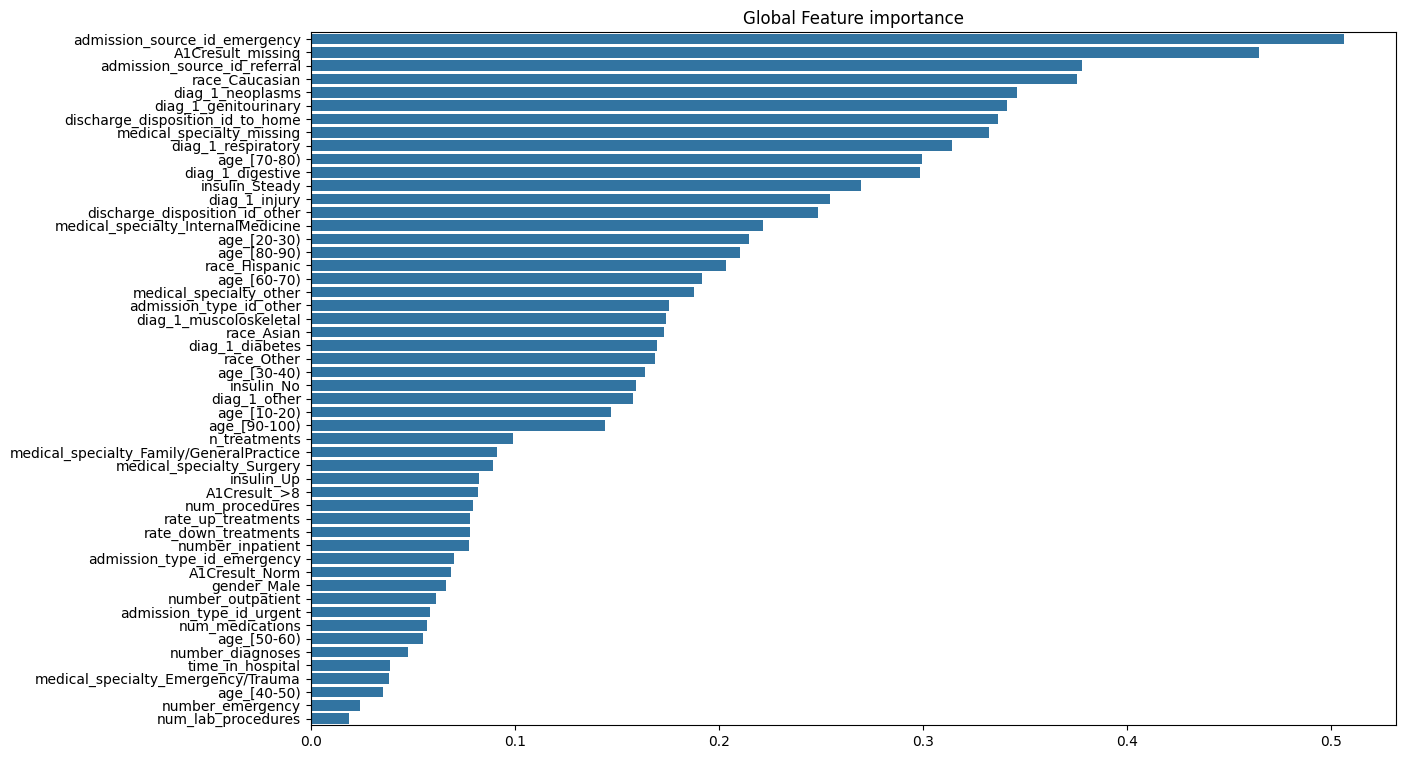

In [38]:
importance = np.mean(coefs_logreg, axis=0)
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(14,9))
sns.barplot(x=importance[indices], y=feature_names[indices])
plt.title("Global Feature importance")
plt.show()

From the global feature importance analysis, looking at the plot, it seems that features from n\_treatments to num\_lab\_procedures have not a great impact in terms of classifying one of the 3 classes. 

It is worth mentioning that this group of features includes almost every numerical variables, meaning that the categorical ones look more influent in this particular model. 

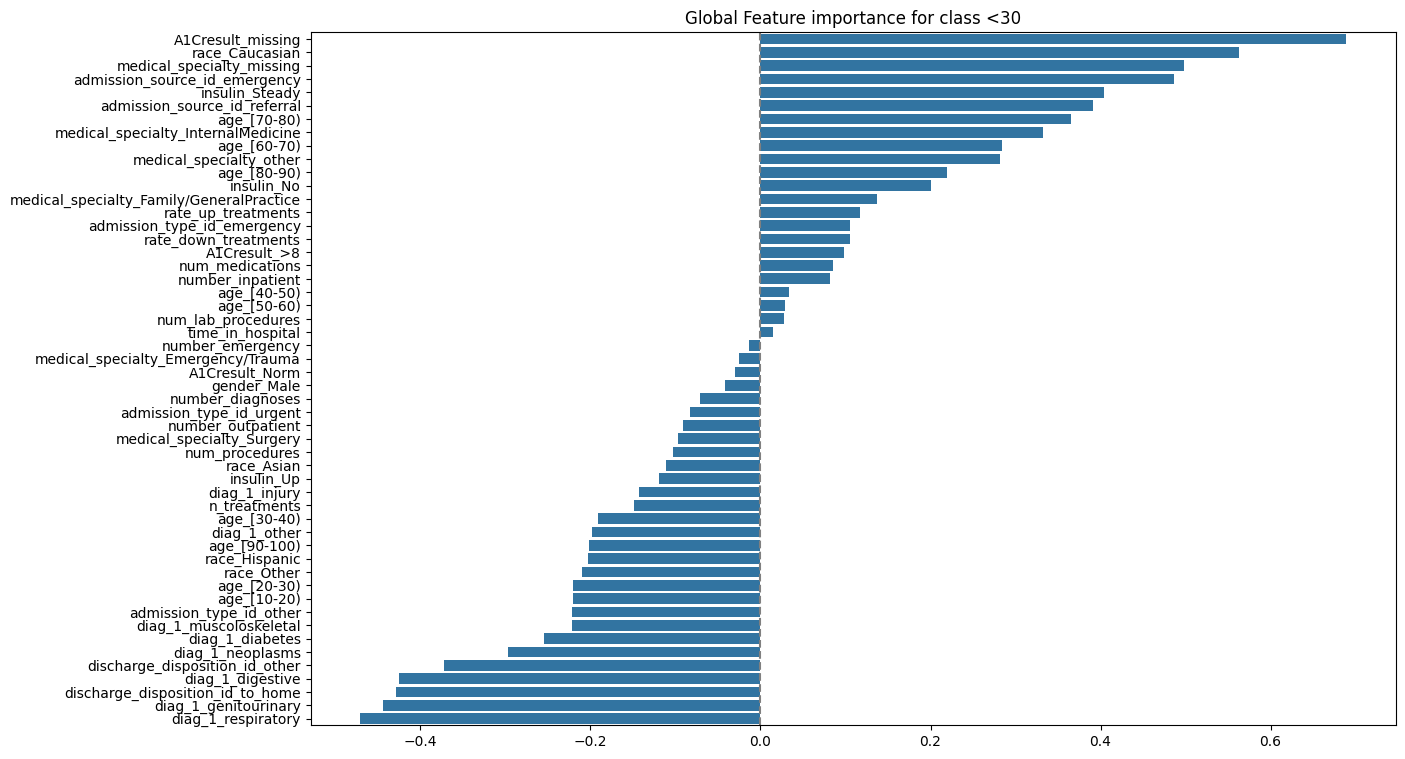

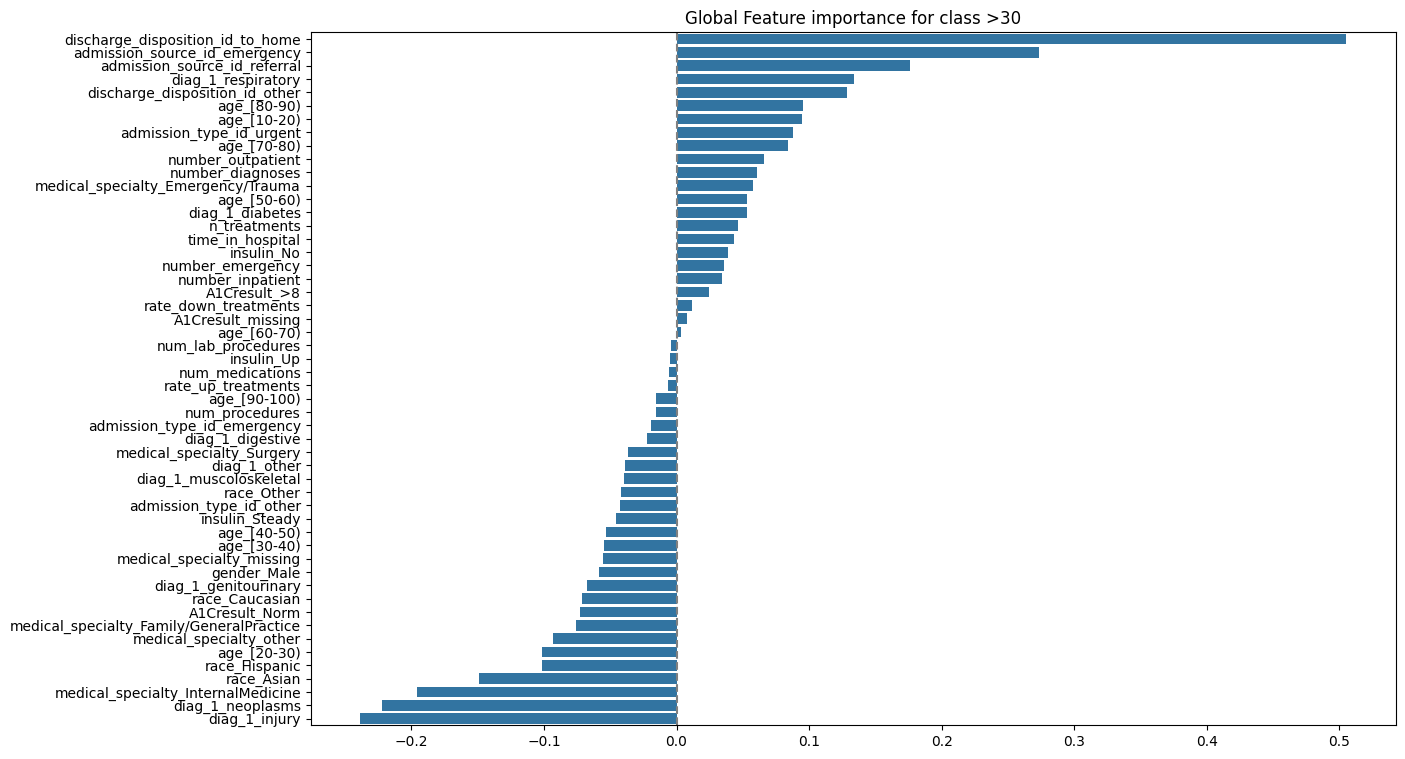

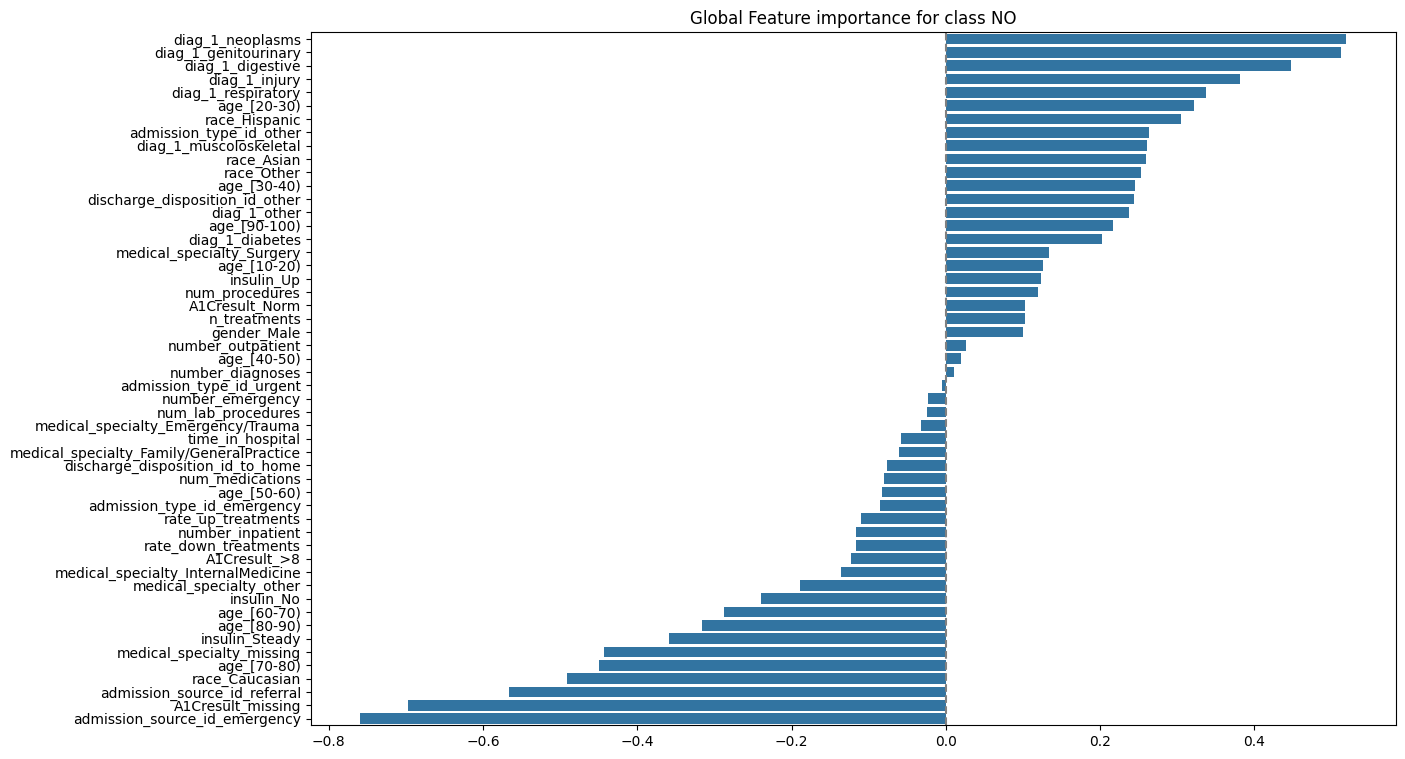

In [ ]:
for i in range(0,3):
    importance = logistic_reg.coef_[i]
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(14,9))
    sns.barplot(x=importance[indices], y=feature_names[indices])
    plt.title(f" Feature importance for class {logistic_reg.classes_[i]}")
    plt.axvline(0, color='gray', linestyle='--')
    plt.show()

Let's comment the three plots of the parameters associated to each class:
- for class '$< 30$'
    $A1cResult$ appears to be an influential feature, particularly when the glycated hemoglobin test was not performed during the visit. This may be due to the fact that in certain cases of hospitalization for critical conditions, the test was not conducted because it was not considered a priority. These critical conditions might be associated with health issues that are likely to reoccur in the short term.
    In fact, also the emergency admission type looks influent as well
- for class '$> 30$'
    the fact that the patient was discharged to home appears to be the most predictive feature. This opens up different possible interpretations—one of them being that in some cases, health problems might have been underestimated, leading to a relapse.
- For the parameters of the "NO" class, 
    several important insights emerge. The most influential factors seem to be certain principal diagnoses, which vary significantly in terms of severity. Among the most predictive variables are diagnoses related to the respiratory and digestive systems, as well as neoplasms.
    For less severe conditions, predicting no hospital readmission is relatively straightforward. In contrast, the presence of neoplasms suggests a different scenario. One possible explanation is that patients with such diagnoses may have initiated a supervised care pathway—including regular check-ups and a tailored treatment plan—which reduces the likelihood of urgent hospital readmission.



### Next Steps: Enhancing Performance and Interpretability
-Feature Space Enrichment (focus on model performance)

-Feature Selection via $L^1$ Regularization (focus on model interpretability)


### Polynomial Mapping of numerical features


At first, we tried to sacrifice some of the model interpretability to obtain some gains in term of prediction power. An attempt was done by introducing in the feature space a polynomial mapping of degree 2 of the continuous variables. 

However, as the learning curve below shows, improvements in term of performances were not enough to justify the choice of a model with such poor interpretability, so we decided to abandon this path.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

preprocessor2 = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
    ]), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns)
])

pipeline2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', LogisticRegression(max_iter=1000, penalty=None))
])


In [ ]:
train_sizes2, train_scores2, val_scores2 = learning_curve(
    estimator=pipeline2,
    X=X_SMOTENC, y=y_SMOTENC,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='f1_macro'
)

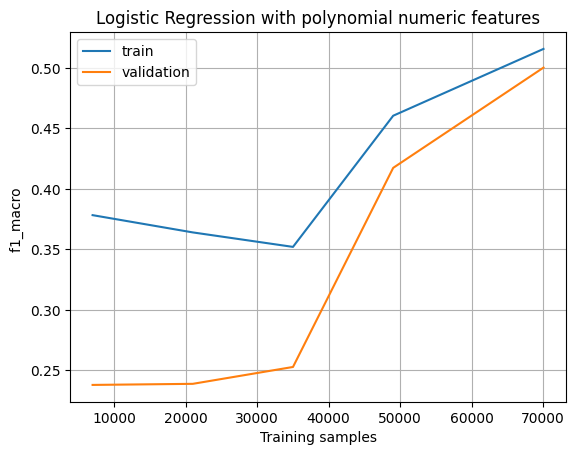

In [ ]:
plt.plot(train_sizes2, train_scores2.mean(axis=1), label='train')
plt.plot(train_sizes2, val_scores2.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("f1_macro ")
plt.title("Logistic Regression with polynomial numeric features")
plt.legend(); plt.grid()
plt.show()

In [ ]:
pipeline2.fit(X_SMOTENC,y_SMOTENC)

In [ ]:
y_pred_poly_logistic = pipeline2.predict(X_test)

In [ ]:
f1_poly_logistic = f1_score(y_test,y_pred_poly_logistic, average='weighted')
f1_poly_logistic

In [ ]:
accuracy_poly_logistic = accuracy_score(y_test,y_pred_poly_logistic)
accuracy_poly_logistic

### Lasso Logistic Regression for model explainability

We try to follow the opposite approach, that is to simplify as much as possible the model without losing too much in terms of predictive performances. 

In [ ]:
pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=1000,
    C=1.0)
)])

In [ ]:
param_grid = {
    'classifier__C': C_range
}

# Grid search con cross-validation
grid_search = GridSearchCV(
    pipeline_lasso,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1, verbose=3
)

grid_search.fit(X_SMOTENC, y_SMOTENC)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['time_in_hospital',
                                                                          'num_lab_procedures',
                                                                          'num_procedures',
                                                                          'num_medications',
                                                                          'number_outpatient',
                                                                          'number_emergency',
                                                                          'number_inpatient',
                                                                          'number_diagnoses',
                                                                          'n_treatments',
                                                                          'rate_down_treatments',
                                                                          'rate_up_treatments']),
                                                                        ('cat',
                                                                         OneHotEncoder...
                                                                          'admission_type_id',
                                                                          'discharge_disposition_id',
                                                                          'admission_source_id',
                                                                          'medical_specialty',
                                                                          'diag_1',
                                                                          'A1Cresult',
                                                                          'insulin'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial',
                                                           penalty='l1',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                           10, 100, 1000]},
             return_train_score=True, scoring='f1_macro', verbose=3)

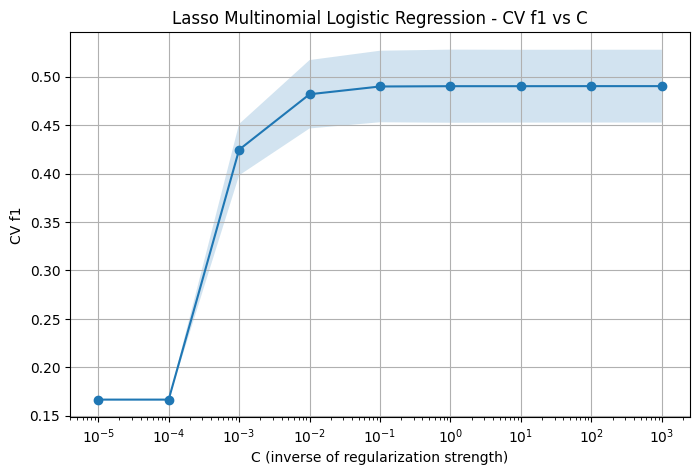

In [ ]:
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

plt.figure(figsize=(8, 5))
plt.semilogx(C_range, mean_scores, marker='o')
plt.fill_between(C_range, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2)
plt.xlabel("C (inverse of regularization strength)")
plt.ylabel("CV f1")
plt.title("Lasso Multinomial Logistic Regression - CV f1 vs C")
plt.grid(True)
plt.show()

### Conservative Feature Selection with Lasso
The main goal of this approach is to simplify the model in order to retrieve more understandable results. At the same time we don't want to lose too much in terms of predictive power, so the selection of the regularization coefficient is done by taking the lowest C (i.e. the highest regularization strength) that still guarantees performances better than a random choice.

In [62]:
pipeline_lasso.set_params(classifier__C = 1e-3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000,
                                    multi_class='multinomial', penalty='l1',
                                    solver='saga'))])

In [ ]:
pipeline_lasso.fit(X_SMOTENC, y_SMOTENC)

In [66]:
lasso_model = pipeline_lasso.named_steps['classifier']
coefs_lasso = np.abs(lasso_model.coef_)

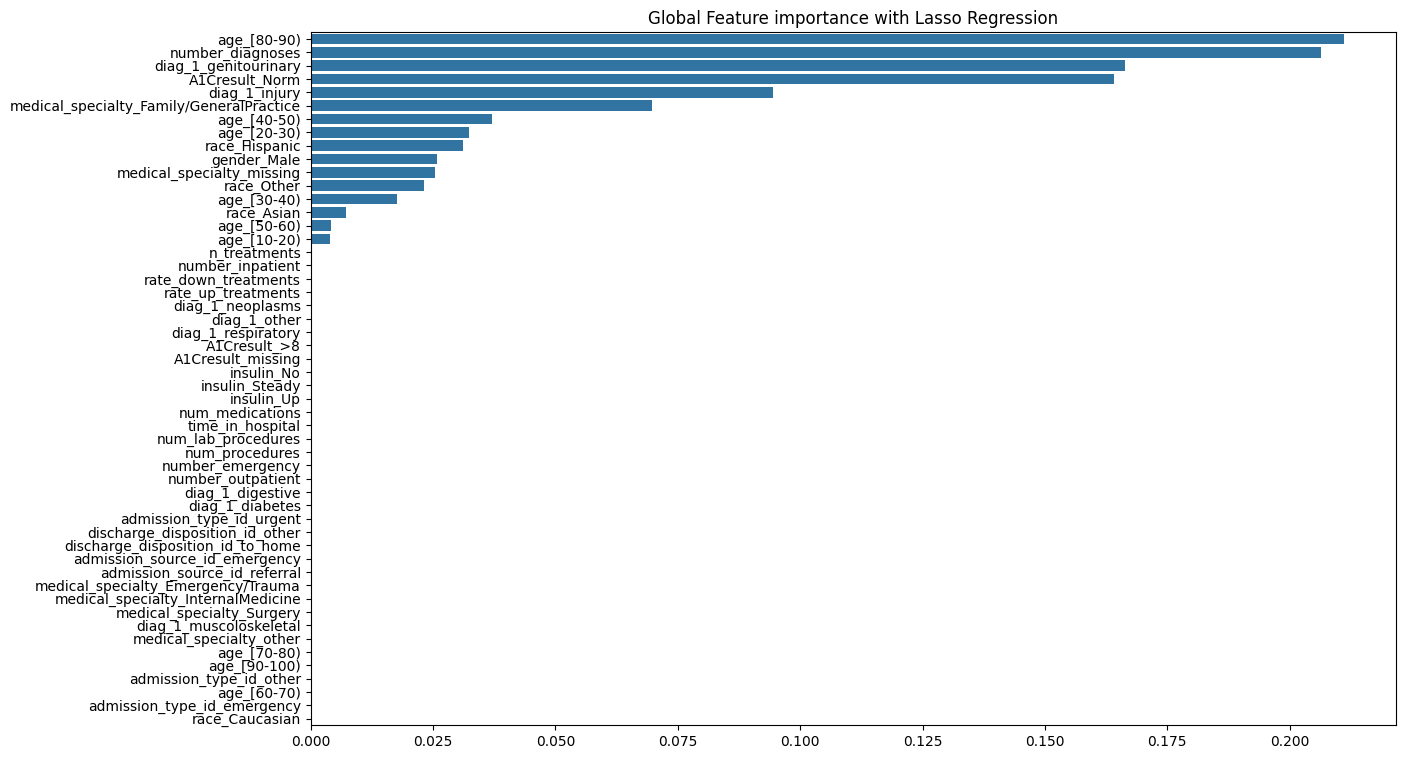

In [67]:
importance_lasso = np.mean(coefs_lasso, axis=0)
indices = np.argsort(importance_lasso)[::-1]

plt.figure(figsize=(14,9))
sns.barplot(x=importance_lasso[indices], y=feature_names[indices])
plt.title("Global Feature importance with Lasso Regression")
plt.show()

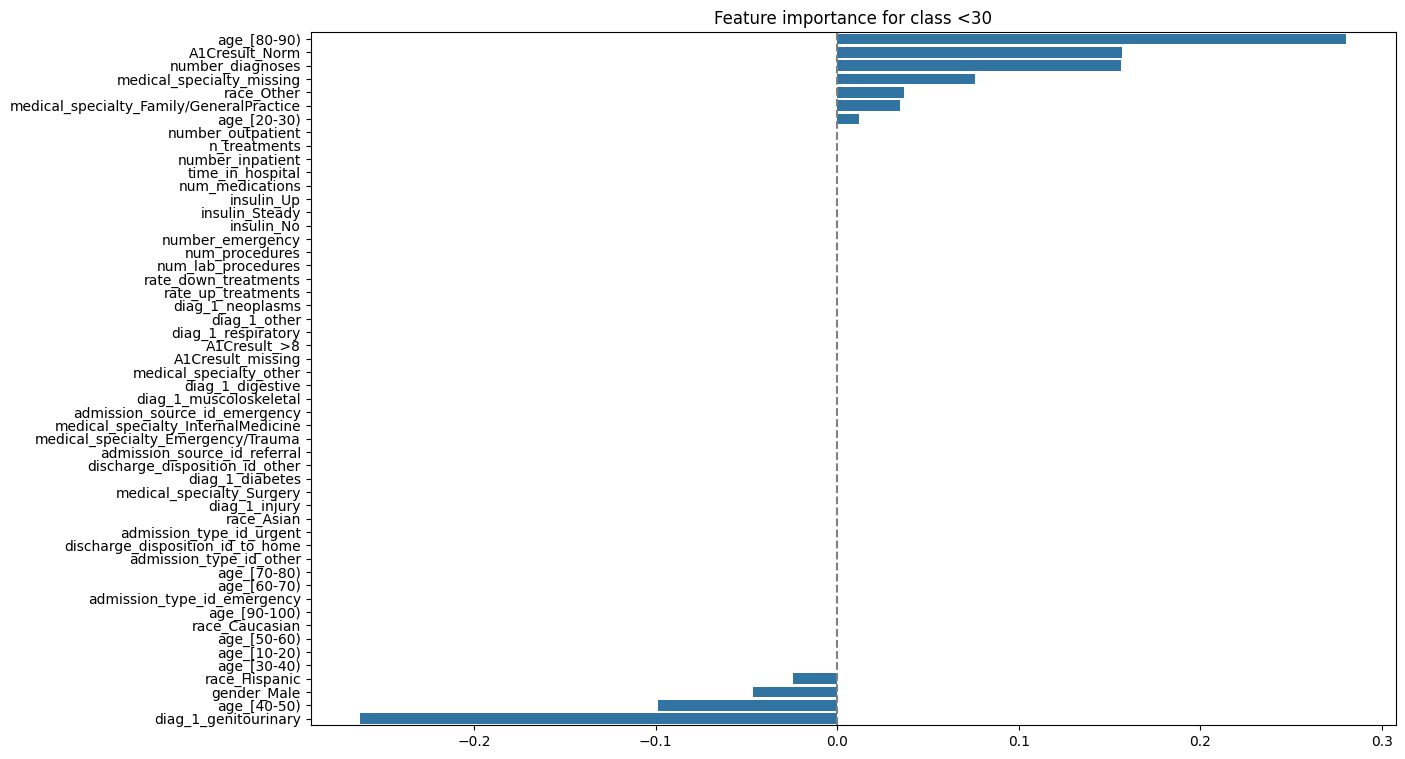

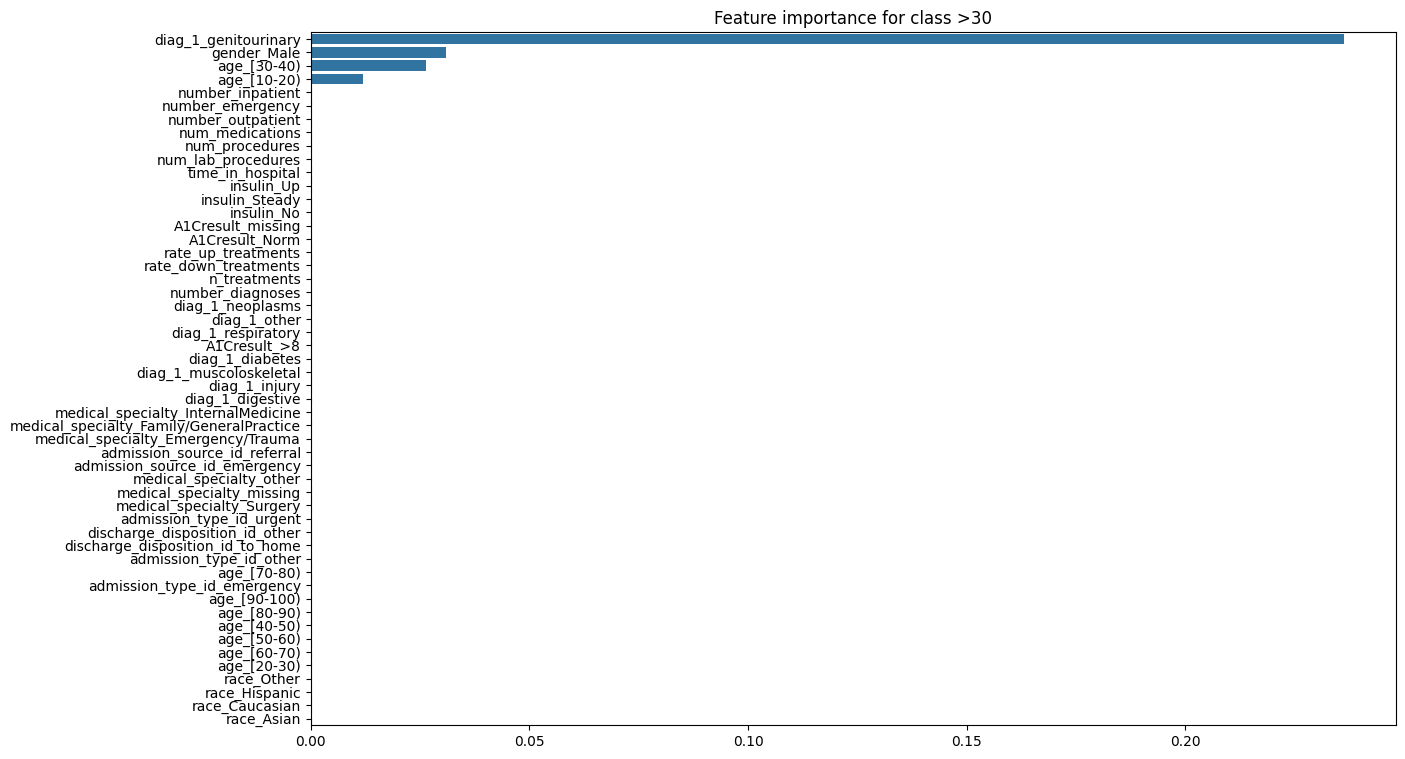

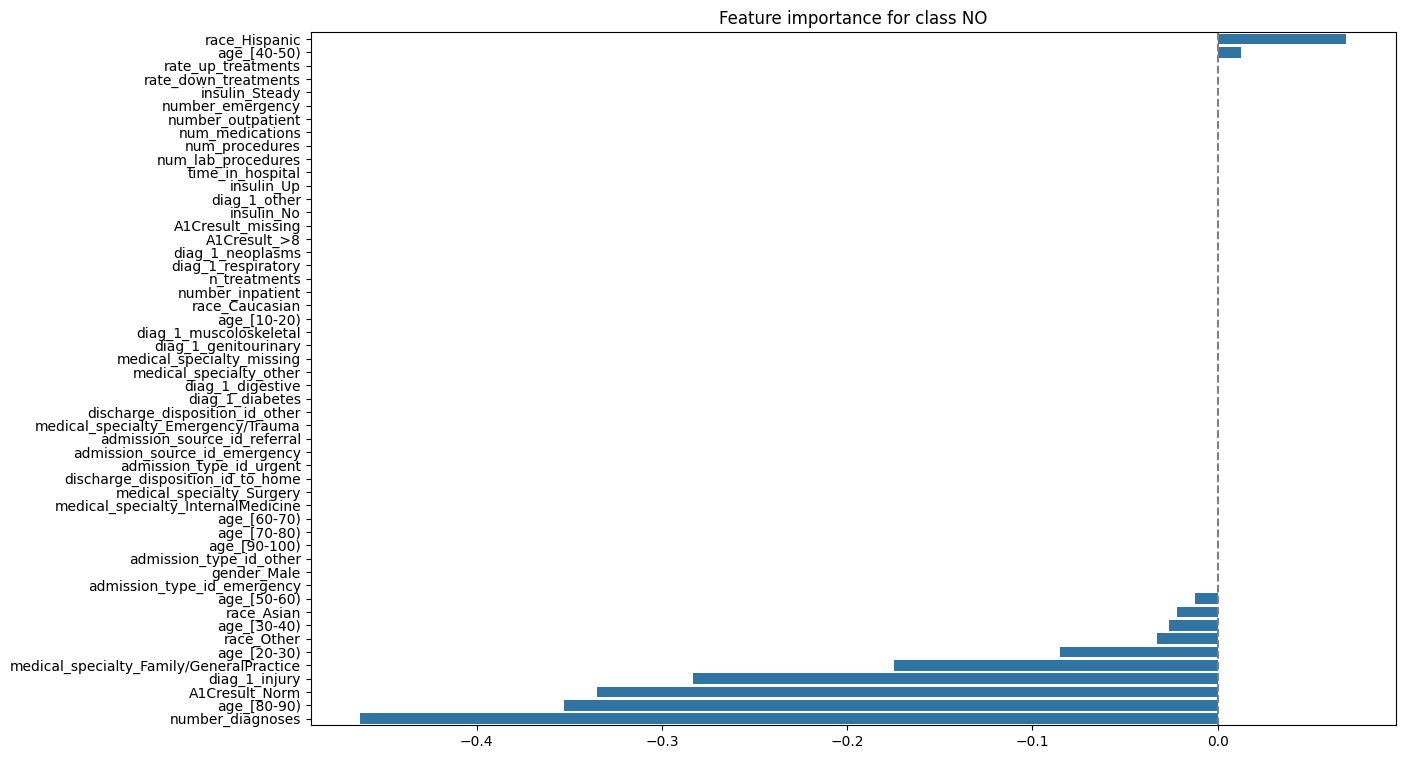

In [69]:
for i in range(0,3):
    importance_lasso_i = lasso_model.coef_[i]
    indices = np.argsort(importance_lasso_i)[::-1]

    plt.figure(figsize=(14,9))
    sns.barplot(x=importance_lasso_i[indices], y=feature_names[indices])
    plt.title(f"Feature importance for class {lasso_model.classes_[i]}")
    plt.axvline(0, color='gray', linestyle='--')
    plt.show()

To summarize the results, after the integrated feature selection offered by Lasso Regression, the most influent coefficients slightly differ from the most significant in Ridge regression. 

This is not totally unusual, as feature selection in Lasso Regression usually helps reduce the effect of some hidden patters of collinearity between variables. Some variables in fact could be significant only with other variables. 

Here, it seems that the age of the patient becomes more significative in predictive terms while using a small amount of features for the classification task.

However, there are also some similarities with the results discovered in Ridge Regression: for example, the principal diagnosis of problems to the  genitourinary system seems very predictive for a new hospitalization which is far in time.



In [64]:
prediction_lasso = pipeline_lasso.predict(X_test)

In [65]:
f1_score(y_test, prediction_lasso, average='weighted')

0.47761834273586207

In [ ]:
accuracy_score(y_test, prediction_lasso)

## From Decision Trees to Random Forest

We now move on implementing a **Decision Tree** model, which in theory allows for much greater complexity and non-linear decision boundaries compared to Logistic Regression. However, this added flexibility comes at the cost of a higher risk of overfitting and increased variance.

Let's start by implementing an extremely simple decision tree, with maximum depth 1, which means 1 split on a single optimal feature

In [ ]:
# define the pipeline
pipeline_tree = Pipeline([('preproc', preprocessor),
                          ('classifier', DecisionTreeClassifier(max_depth=1, random_state=42))])
# fit the model
pipeline_tree.fit(X_resampled,y_resampled)

# make predictions on the training and test set
y_pred_training=pipeline_tree.predict(X_resampled)
y_pred=pipeline_tree.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_training, average='weighted'))

# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))


On training set:
Accuracy : 0.4114678952047756
F1 (weighted): 0.3286795182644264
On test set:
Accuracy : 0.3616425571628558
F1 (weighted): 0.3517951012787853


The performance on the test set is just above the trivial guess of 0.33.  

In [79]:
# cross-validation accuracy scores
scores_tree = cross_val_score(pipeline_tree, X_resampled, y_resampled, cv=5)
scores_tree

array([0.35757996, 0.42206443, 0.42543733, 0.41579585, 0.42601466])

Let's now go on exploring how our Decision Tree baseline model learns as more data are fed in...

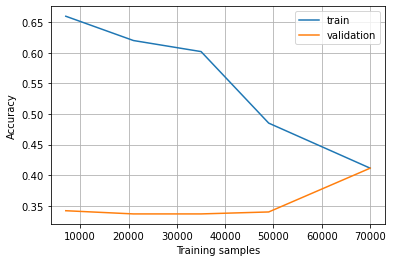

In [25]:
train_sizes_stump, train_scores_stump, val_scores_stump = learning_curve(
    estimator=pipeline_tree,
    X=X_resampled, y=y_resampled,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='accuracy'
)

plt.plot(train_sizes_stump, train_scores_stump.mean(axis=1), label='train')
plt.plot(train_sizes_stump, val_scores_stump.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("Accuracy")
plt.legend(); plt.grid()
plt.show()

We see that a single Decision Tree, with depth 1, is a biased model, being extremely simple.

Here below, we proceed analysing how the **maximum tree depth** impacts on Variance-Bias tradeoff:

In [26]:
max_depth_range = range(1,30)
train_scores_trees, val_scores_trees = validation_curve(
    pipeline_tree, X_resampled, y_resampled,
    param_name="classifier__max_depth", param_range=max_depth_range,
    cv=5, scoring="f1_macro"
)

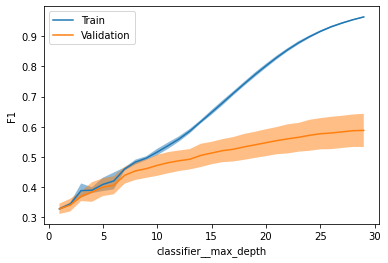

In [28]:
display_trees = ValidationCurveDisplay(
    param_name="classifier__max_depth", param_range=max_depth_range,
    train_scores=train_scores_trees, test_scores=val_scores_trees, score_name="F1"
)
display_trees.plot()
plt.legend(['Train', 'Validation'])
plt.show()

We now perform a **GridSearch** to be more accurate at choosing the most appropriate max_depth, being aware of the fact that the tuned model will be prone to overfitting, as shown by the plot above.


In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# pipeline
pipeline_tree = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# grid of hyperparameter to search
param_grid = {
    'classifier__max_depth': range(15, 30)
}

# grid search
grid = GridSearchCV(pipeline_tree, param_grid, cv=5, n_jobs=-1)

# tune hyperpar
grid.fit(X_resampled, y_resampled)
print(grid.best_params_)

{'classifier__max_depth': 29}


Now, let's fit the model and perform a final evaluation

In [61]:
# fit model
final_model=grid.best_estimator_
final_model.fit(X_resampled, y_resampled)

#final evaluation
# make predictions on the training and test set
y_pred_tree_training=final_model.predict(X_resampled)
y_pred_tree=final_model.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_tree_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_tree_training, average='weighted'))

# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_tree))
print("F1 (weighted):", f1_score(y_test, y_pred_tree, average='weighted'))

On training set:
Accuracy : 0.9739051115960604
F1 (weighted): 0.9739051675843498
On test set:
Accuracy : 0.437120858609426
F1 (weighted): 0.4552982983903508


## Random Forest

To improve upon a single decision tree, which often suffers from high variance, we implement a **Random Forest** model. Random Forest reduces variance by averaging the predictions of many decision trees trained on different subsets of the data and features.

Let's run a 'baseline' Random Forest:

In [24]:
pipeline_rf = Pipeline([('preproc', preprocessor),
                          ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

Let's start by visualizing whether the model learns as data are fed in, by looking at the F1 score on the training and validation sets 

In [ ]:
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    estimator=pipeline_rf,
    X=X_resampled, y=y_resampled,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='f1_macro'
)

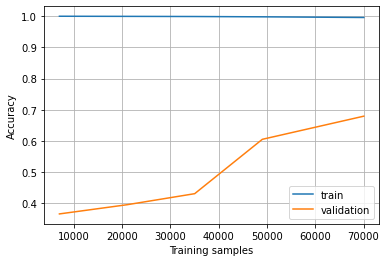

In [ ]:
plt.plot(train_sizes_rf, train_scores_rf.mean(axis=1), label='train')
plt.plot(train_sizes_rf, val_scores_rf.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("F1")
plt.legend(); plt.grid()
plt.show()


Notice that the blue 'train' line remains at 1.0 across all configurations.
This is because Random Forest, with 100 trees, that can be as deep as possible by default, is complex enough to perfectly fit the resampled training data, achieving a maximum F1 score of 1.

Here below with the function 'validation_curve' of sklearn we see how the number of trees, which is represented by n_estimator, affects the performance of the model.

In [ ]:
n_estimators_range = [10,100,1000]
train_scores_rf, val_scores_rf = validation_curve(
    pipeline_rf, X_resampled, y_resampled,
    param_name="classifier__n_estimators", param_range=n_estimators_range,
    cv=5, scoring="f1_macro"
)

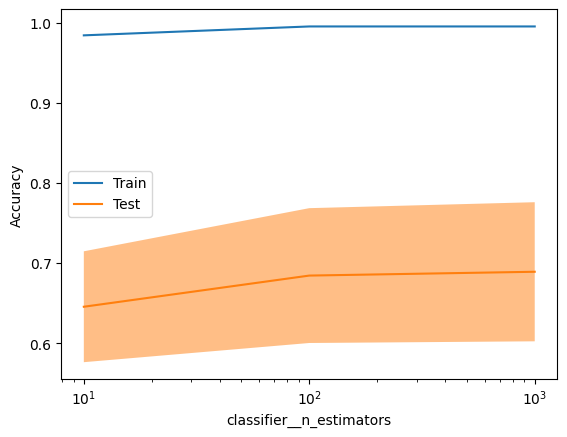

In [ ]:
display_rf = ValidationCurveDisplay(
    param_name="classifier__n_estimators", param_range=np.array(n_estimators_range),
    train_scores=train_scores_rf, test_scores=val_scores_rf, score_name="F1"
)
display_rf.plot()
plt.legend(["Train", "Validation"])
plt.show()

 Let's see how the Random Forest baseline performs.

In [ ]:
#Keywords: SMOTENC, no hyperpar-tuning

# Define a pipeline that first performs preprocessing and then fits a RandomForestClassifier
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),  # applies transformations to both numerical and categorical variables
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train pipeline on resampled data
pipeline_rf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_rf_training=pipeline_rf.predict(X_resampled)
y_pred_rf = pipeline_rf.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_rf_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_rf_training, average='weighted'))


# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("F1 (weighted):", f1_score(y_test, y_pred_rf, average='weighted'))

On training set:
Accuracy : 0.9998729894812197
F1 (weighted): 0.9998729914808822
On test set:
Accuracy : 0.5307979468035464
F1 (weighted): 0.5227970225962216


### Cross-Validation of Random Forest

Let's now finetune the hyperparameters of the Random Forest model to improve its generalization performance.

In [65]:
param_grid = {
    'classifier__max_features': ['sqrt', 'log2', 0.5, 0.7],
    'classifier__n_estimators': [10, 100, 500]
}

grid_search = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid,         
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

grid_search.fit(X_resampled, y_resampled)

print("Best parameters :", grid_search.best_params_)
print("Best CV F1 Macro:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters : {'classifier__max_features': 0.5, 'classifier__n_estimators': 500}
Best CV F1 Macro: 0.64427005866446


Rerunning the model setting the optimal parameters...

In [ ]:
#keywords:SMOTENC, hyperpar-tuned

# Define a pipeline that first performs preprocessing and then fits a RandomForestClassifier
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),  # applies transformations to both numerical and categorical variables
    ('classifier', RandomForestClassifier(n_estimators=500, max_features=0.5, random_state=42))
])

# Train pipeline on resampled data
pipeline_rf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_rf_training = pipeline_rf.predict(X_resampled)
y_pred_rf = pipeline_rf.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_rf_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_rf_training, average='weighted'))


# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("F1 (weighted):", f1_score(y_test, y_pred_rf, average='weighted'))

On training set:
Accuracy : 0.9998729894812197
F1 (weighted): 0.9998729918801621
On test set:
Accuracy : 0.5348810079328045
F1 (weighted): 0.5257403639959874


This model improves F1 performances(we will see that this model in terms of performances is actually among the best ones!)

### Two Roads in Feature Engineering: Adding New Features vs. Selecting the Best

As with Logistic Regression, we follow a two-fold approach: on one hand, we assess whether adding polynomial terms leads to a significant improvement in model performance; on the other hand, we conduct a feature importance analysis and use it to guide feature selection, with the goal of enhancing model explainability.

 We enrich the feature space with interaction terms to capture higher-order dependencies potentially missed by Random Forest.
 We now define a new preprocessor including interaction terms up to degree 2 to enrich the feature space.

In [28]:
preprocessor3 = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('scaler', StandardScaler())
    ]), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns)
])

In [82]:
#Keywords: SMOTENC, no hyperpar-tuning, preprocessor3

# Define a pipeline that first performs preprocessing and then fits a RandomForestClassifier
pipeline_rf3 = Pipeline([
    ('preprocessor', preprocessor3),  
    ('classifier', RandomForestClassifier(n_estimators=100,  random_state=42))
])

# Train pipeline on resampled data
pipeline_rf3.fit(X_resampled, y_resampled)

# Make predictions on the training and test set
y_pred_rf3_training= pipeline_rf3.predict(X_resampled)
y_pred_rf3 = pipeline_rf3.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_rf3_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_rf3_training, average='weighted'))

# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf3))
print("F1 (weighted):", f1_score(y_test, y_pred_rf3, average='weighted'))

On training set:
Accuracy : 0.9998729894812197
F1 (weighted): 0.9998729916806537
On test set:
Accuracy : 0.5461969202053196
F1 (weighted): 0.5315237581251913


The performance of the model above — a Random Forest trained on an extended feature space — slightly improves upon that of the model trained on the original feature set. 

Once again, we see how the number of trees which is represented by n_estimator affects the performance of the model.

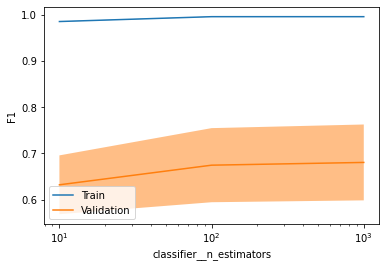

In [56]:
n_estimators_range = [10,100,1000]
train_scores_rf, val_scores_rf = validation_curve(
    pipeline_rf3, X_resampled, y_resampled,
    param_name="classifier__n_estimators", param_range=n_estimators_range,
    cv=5, scoring="f1_macro"
)
display_rf = ValidationCurveDisplay(
    param_name="classifier__n_estimators", param_range=np.array(n_estimators_range),
    train_scores=train_scores_rf, test_scores=val_scores_rf, score_name="F1"
)
display_rf.plot()
plt.legend(["Train", "Validation"])
plt.show()

Cross-Validation again on extended feature space:

In [ ]:
# define parameter grid
param_grid = {
    'classifier__max_features': ['sqrt', 'log2', 0.5, 0.7],
    'classifier__n_estimators': [10, 100, 500]
}

# perform GridSearch on optimal parameters
grid_search = GridSearchCV(
    pipeline_rf3,
    param_grid=param_grid,         
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

# Fit the model
grid_search.fit(X_resampled, y_resampled)

print("Best parameters :", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters : {'classifier__max_features': 0.5, 'classifier__n_estimators': 500}


Rerunning the model with the optimal hyperparameters:

In [ ]:
#Keywords: SMOTENC, hyperpar-tuned

# Define a pipeline that first performs preprocessing and then fits a RandomForestClassifier
pipeline_rf4 = Pipeline([
    ('preprocessor', preprocessor),  # applies transformations to both numerical and categorical variables
    ('classifier', RandomForestClassifier(n_estimators=500, max_features=0.5 , random_state=42))
])

# Train pipeline on resampled data
pipeline_rf4.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_rf4_training = pipeline_rf4.predict(X_resampled)
y_pred_rf4 = pipeline_rf4.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_rf4_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_rf4_training, average='weighted'))


# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf4))
print("F1 (weighted):", f1_score(y_test, y_pred_rf4, average='weighted'))

On training set:
Accuracy : 0.9998729894812197
F1 (weighted): 0.9998729918801621
On test set:
Accuracy : 0.5348810079328045
F1 (weighted): 0.5257403639959874


Notice that F1 performance on the test set does not increase after hyperparameter tuning. This may be related to the fact that this model with this data has reached a 'plateau'.

Given the marginal gain and the trade-off in interpretability, we favor the original feature space. We now proceed with feature importance analysis and selection based on this more interpretable setup.

## Feature Importance and Selection for Random Forest

We compute feature significance using two approaches. We start with **feature_importances_**, based on Gini scores, then we go on computing **permutation_importance**, as explained below.

What is feature importance for feature j? 

$$\text{Feature Importance}_j = \frac{1}{T} \sum_{t=1}^{T} \sum_{\text{nodes m with split on j}} \frac{N_{t,m}}{N} \Delta I_{t,m}$$
where:
- $T$ is the number of trees in the forest
- $N_t,m$ is the number of samples in node m of tree $t$
- $N$ is the total number of samples in the training size
- $\Delta I_{t,m}$ is the Gini index for the split on node $m$ on tree $t$

In [31]:
# Estract the model from the pipeline
rnd_clf=pipeline_rf.named_steps['classifier']

# feature importance
rnd_clf.feature_importances_

array([0.08552347, 0.16182645, 0.05264537, 0.13050189, 0.01881137,
       0.01110071, 0.0191085 , 0.05887502, 0.04318221, 0.03078819,
       0.02693247, 0.00069075, 0.01722843, 0.00146868, 0.00137721,
       0.02553525, 0.00089962, 0.00201538, 0.00442967, 0.00869901,
       0.01157699, 0.01544194, 0.01620721, 0.01414723, 0.00419041,
       0.01036637, 0.00046841, 0.01038416, 0.00079723, 0.01522167,
       0.01137788, 0.00705819, 0.00403089, 0.00474655, 0.00631102,
       0.00337711, 0.01739139, 0.00572844, 0.00918801, 0.0112486 ,
       0.00813739, 0.0093152 , 0.00586853, 0.00494449, 0.01689574,
       0.01311583, 0.00231581, 0.00227045, 0.01548458, 0.0165837 ,
       0.01617134, 0.00799754])

In [32]:
# get the transformer OneHotEncoder from the pipeline
ohe = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat']

# Get the names of the numeric features 
num_feats = numeric_columns

# Get the names of the categorical features 
cat_feats = ohe.get_feature_names_out(categoric_columns)

# Combine the names of the features
feature_names = np.concatenate([num_feats, cat_feats])

<AxesSubplot:>

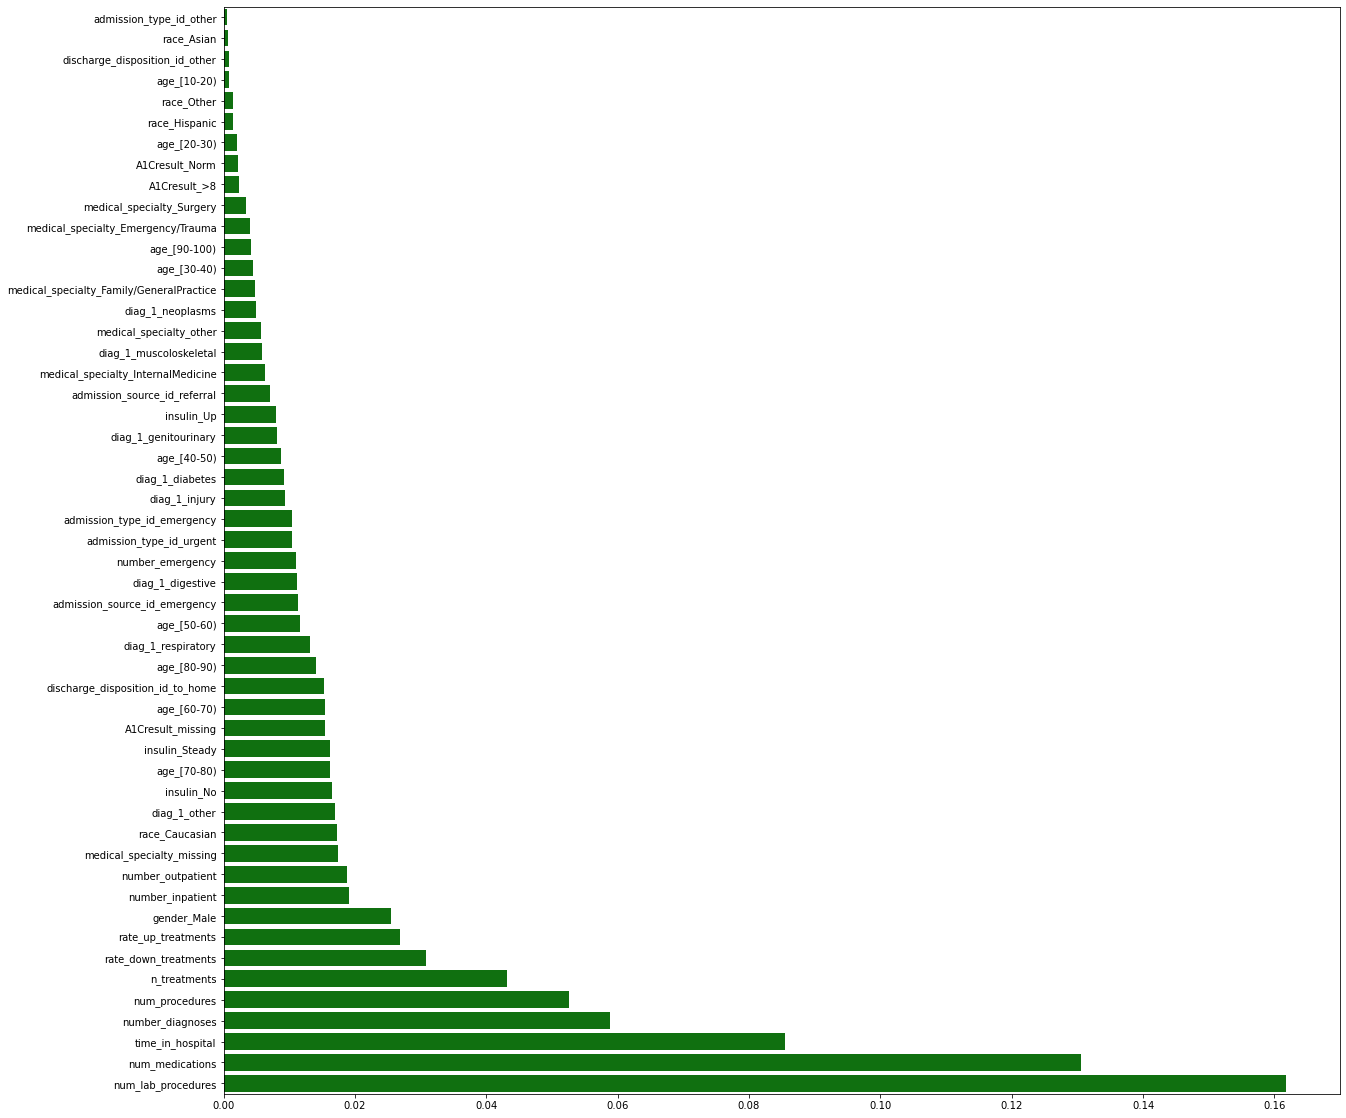

In [33]:
GiniScore,j=np.sort(rnd_clf.feature_importances_),np.argsort(rnd_clf.feature_importances_)
plt.figure(figsize=(20, 20)) 
sns.barplot(y=feature_names[j], x=GiniScore, color='g', )

Notice that impurity based feature importance, computed as above, may be biased towards numerical features, since they allow many more splits than categorical ones with few categories. Hence, it improves almost randomly the model performance. This appears to be true in our case.

Let's now compute the **permutation importance**.

This method is known to overcome the bias of impurity-based feature importance, especially when dealing with numerical features or categorical ones with many levels.
The idea is simple: we measure how the model's performance metric (e.g. accuracy, F1) drops when a single feature's values are randomly shuffled.
The larger the drop, the more important the feature is. To make the estimate more stable, the process is repeated several times and averaged.

Let's compute it below.

In [47]:
def f1_weighted_score(model, X, y):
    y_pred = model.predict(X)
    return f1_score(y, y_pred, average='weighted')

# Compute importances
result = permutation_importance(pipeline_rf, X_test, y_test, n_repeats=5, random_state=42, scoring=f1_weighted_score)

# Create Series and sort
f_importances = pd.Series(result.importances_mean, index=X_test.columns)
f_importances_sorted = f_importances.sort_values()  



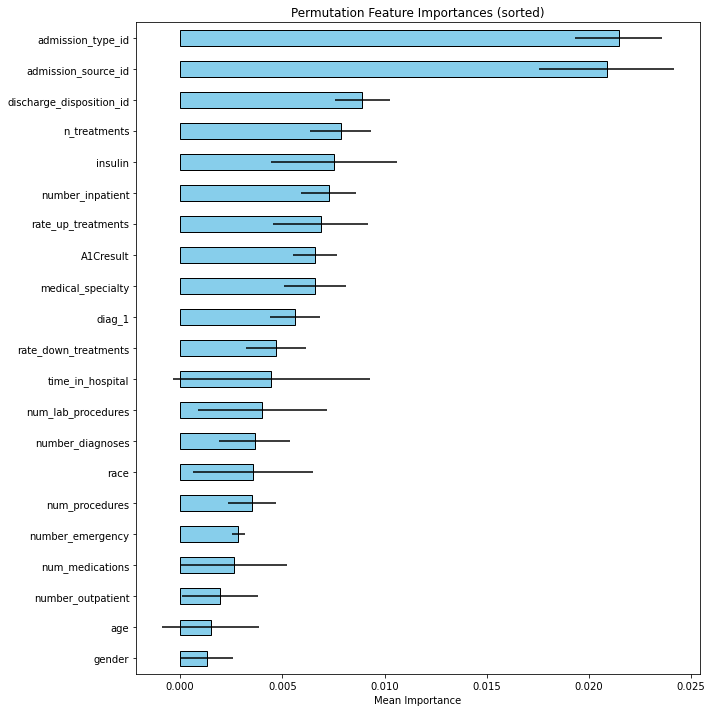

In [49]:
# Plot
plt.figure(figsize=(10, 10))
f_importances_sorted.plot.barh(
    xerr=result.importances_std[[X_test.columns.get_loc(col) for col in f_importances_sorted.index]],  
    color="skyblue",
    edgecolor="black"
)
plt.title("Permutation Feature Importances (sorted)")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

Here above, we see that as a matter of fact the most relevant features are categorical. Random Forest tend to detect the importance of **admission_type_id** and **admission_source_id**. 

As for 'admission_type_id', this is reasonable, as 'emergence' or 'urgent' admissions often indicate more severe conditions, increasing readmission risk, while 'elective' refer to not so life-death procedures. Talking about 'admission_source_id', once again the reasoning is similar: 'emergency' refers to much urgent patients than 'referral'.
These features act as proxies for clinical urgency and patient fragility at entry. 
Notice that 'admission_source_id' is also very significant in the logistic regression.

 ### Feature Selection for Random Forest

While we have already identified two features as particularly significant, removing all others would be too drastic. Therefore, we set a feature importance **threshold of 0.005**, which retains approximately 2/3 of the variables and ensures a balance between simplification and preserving predictive power.

In [ ]:
threshold = 0.005
low_importance = f_importances_sorted[f_importances_sorted < threshold]
selected_features=[]
for feature, importance in low_importance.items():
    selected_features.append(feature)

print(selected_features)


['gender', 'age', 'number_outpatient', 'num_medications', 'number_emergency', 'num_procedures', 'race', 'number_diagnoses', 'num_lab_procedures', 'time_in_hospital', 'rate_down_treatments']


pandas.core.series.Series

In [ ]:
X_resampled_FeatureSel_rf=X_resampled.drop(selected_features, axis=1, inplace=False)
X_test_FeatureSel_rf=X_test.drop(selected_features, axis=1, inplace=False)

# numeric and categorical features
numeric_columns_FeatureSel = X_resampled_FeatureSel_rf.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_columns_FeatureSel = X_resampled_FeatureSel_rf.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

#define preprocessor
preprocessor_FeatureSel = ColumnTransformer([('num', StandardScaler(), numeric_columns_FeatureSel),
                                  ('cat',OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns_FeatureSel )])

# Define a pipeline 
pipeline_rf_FeatureSel = Pipeline([
    ('preprocessor', preprocessor_FeatureSel), 
    ('classifier', RandomForestClassifier(n_estimators=500, max_features=0.5 , random_state=42))
])

# Train pipeline on resampled data
pipeline_rf_FeatureSel.fit(X_resampled_FeatureSel_rf, y_resampled)

# Make predictions on the test set
y_pred_FeatureSel_rf_training = pipeline_rf_FeatureSel.predict(X_resampled_FeatureSel_rf)
y_pred_FeatureSel_rf = pipeline_rf_FeatureSel.predict(X_test_FeatureSel_rf)


# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_FeatureSel_rf_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_FeatureSel_rf_training, average='weighted'))


# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_FeatureSel_rf))
print("F1 (weighted):", f1_score(y_test, y_pred_FeatureSel_rf, average='weighted'))


On training set:
Accuracy : 0.6341866130913205
F1 (weighted): 0.6344117535117745
On test set:
Accuracy : 0.4437704153056463
F1 (weighted): 0.4648913816358524


After removing the unimportant features, we see that the performance of the model slightly decreases. However, this **loss is minimal** with respect to the number of features that have been excluded. Furthermore, it may positively contribute to model explainability. We investigate it below.

Now, let's see again how important are the remained features...

In [59]:
# Compute importances
result_FeatureSel = permutation_importance(pipeline_rf_FeatureSel, X_test_FeatureSel_rf, y_test, n_repeats=5, random_state=42, scoring=f1_weighted_score)

# Create Series and sort
f_importances_FeatureSel = pd.Series(result_FeatureSel.importances_mean, index=X_test_FeatureSel_rf.columns)
f_importances_sorted_FeatureSel = f_importances_FeatureSel.sort_values()  

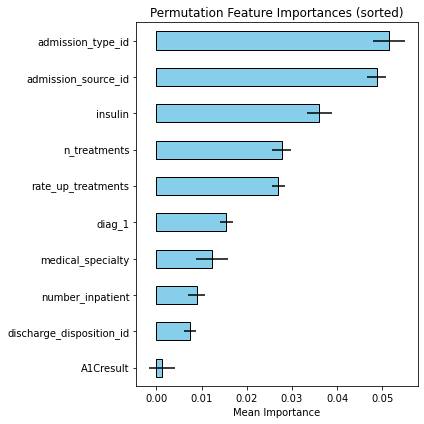

In [65]:
# Plot
plt.figure(figsize=(6, 6))
f_importances_sorted_FeatureSel.plot.barh(
    xerr=result_FeatureSel.importances_std[[X_test_FeatureSel_rf.columns.get_loc(col) for col in f_importances_sorted_FeatureSel.index]],  
    color="skyblue",
    edgecolor="black"
)
plt.title("Permutation Feature Importances (sorted)")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

We see that the 2 most significant features remain such. Also the following 3 are important in the original model. On the other hand, 'discharge_disposition_id' drops a little. 

Let's now go on trying a different model...

## AdaBoost

 Now let's try a different model, still based on decision trees: **Boosting**.

 While Random Forest reduces overfitting by averaging many decision trees (bagging), Boosting works differently: it builds generally small trees sequentially, where each new tree attempts to correct the errors made by the previous ones.

 This iterative process helps to **reduce bias** and often results in better performance, especially on more complex tasks.
 Let's see if Boosting can outperform our previous models.

We now proceed with defining and training an AdaBoost model. 

In [ ]:
base_clf = DecisionTreeClassifier(max_depth=3)

# Define pipeline: preprocessing + AdaBoost classifier
pipeline_boost = Pipeline([('preprocessor', preprocessor),
                          ('classifier', AdaBoostClassifier(estimator=base_clf, n_estimators=500))])


# Hyperparameter grid 
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__estimator__max_depth': [1, 3, 5]
}

# Perform Grid Search 
grid_search = GridSearchCV(
    pipeline_boost,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,
    verbose=3,
    n_jobs=-1,
    error_score='raise'
)

# Fit on resampled (balanced) training data
grid_search.fit(X_resampled, y_resampled)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['time_in_hospital',
                                                                          'num_lab_procedures',
                                                                          'num_procedures',
                                                                          'num_medications',
                                                                          'number_outpatient',
                                                                          'number_emergency',
                                                                          'number_inpatient',
                                                                          'number_diagnoses',
                                                                          'n_treatments',
                                                                          'rate_down_treatments',
                                                                          'rate_up_treatments']),...
                                                                          'admission_type_id',
                                                                          'discharge_disposition_id',
                                                                          'admission_source_id',
                                                                          'medical_specialty',
                                                                          'diag_1',
                                                                          'A1Cresult',
                                                                          'insulin'])])),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                           n_estimators=500))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__max_depth': [1, 3, 5],
                         'classifier__n_estimators': [100, 300, 500]},
             scoring='f1_macro', verbose=3)

In [67]:
# Extract best model from the grid search
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the train and test set
y_pred_boost_train = best_model.predict(X_resampled)
y_pred_boost = best_model.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_boost_train))
print("F1 (weighted):", f1_score(y_resampled, y_pred_boost_train, average='weighted'))

# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_boost))
print("F1 (weighted):", f1_score(y_test, y_pred_boost, average='weighted'))


Best Parameters: {'classifier__estimator__max_depth': 5, 'classifier__n_estimators': 500}
On training set:
Accuracy : 0.763991363284723
F1 (weighted): 0.764042918433494
On test set:
Accuracy : 0.5029164722351843
F1 (weighted): 0.505336200599442


### Feature importance for AdaBoost

Here below, as usual, we try 2 appraoches: impurity-based feature importance and permutation importance.

1.Impurity-based feature importance:

In [68]:
# Estract the model from the pipeline
boost_clf=best_model.named_steps['classifier']

# feature importance
boost_clf.feature_importances_

array([0.0836403 , 0.19823771, 0.05390896, 0.13592599, 0.02069985,
       0.01066475, 0.01733604, 0.06362067, 0.03638162, 0.01725502,
       0.01592658, 0.00118276, 0.01521697, 0.00147804, 0.00143524,
       0.02570791, 0.00048334, 0.00168864, 0.00297707, 0.00767205,
       0.01340012, 0.01521293, 0.01519856, 0.01331816, 0.00403773,
       0.01126983, 0.00055496, 0.00932697, 0.00051228, 0.01838655,
       0.01113634, 0.010632  , 0.00650157, 0.00554869, 0.01075146,
       0.00485896, 0.01400101, 0.0075901 , 0.00676333, 0.01215025,
       0.00782732, 0.00783742, 0.00526335, 0.00490381, 0.01393353,
       0.01117381, 0.00551878, 0.00476353, 0.00766088, 0.01192764,
       0.01294304, 0.00365558])

In [69]:
# get the transformer OneHotEncoder from the pipeline
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']

# Get the names of the numeric features 
num_feats = numeric_columns

# Get the names of the categorical features 
cat_feats = ohe.get_feature_names_out(categoric_columns)

# Combine the names of the features
feature_names = np.concatenate([num_feats, cat_feats])

<AxesSubplot:>

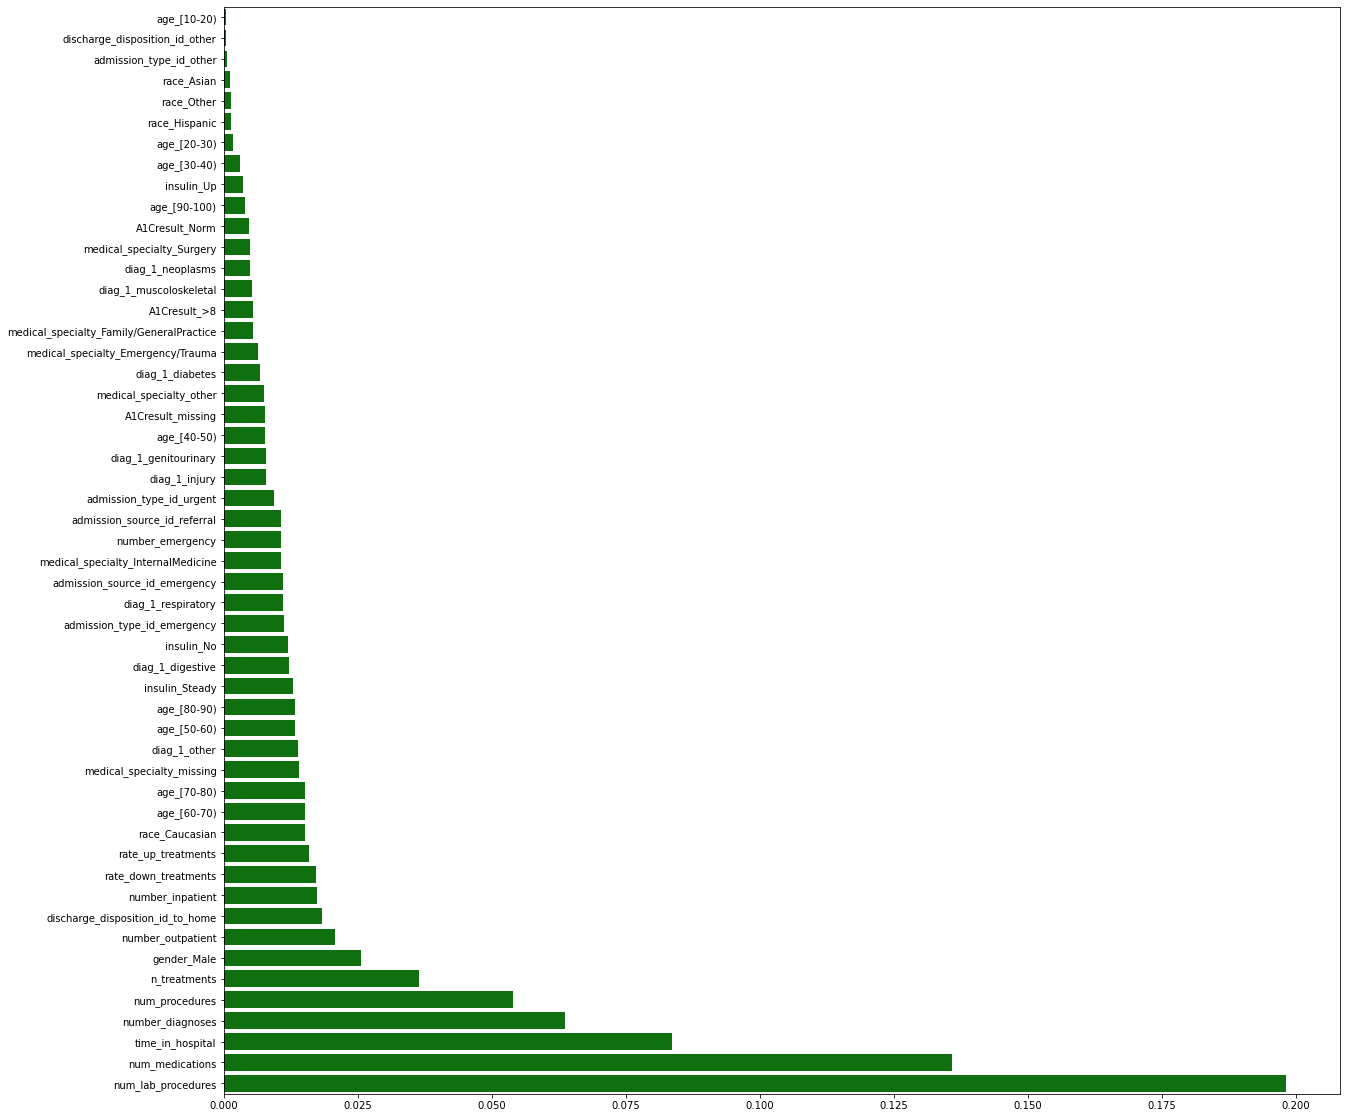

In [70]:
GiniScore,j=np.sort(boost_clf.feature_importances_),np.argsort(boost_clf.feature_importances_)
plt.figure(figsize=(20, 20)) 
sns.barplot(y=feature_names[j], x=GiniScore, color='g', )

2.Permutation importance

<AxesSubplot:>

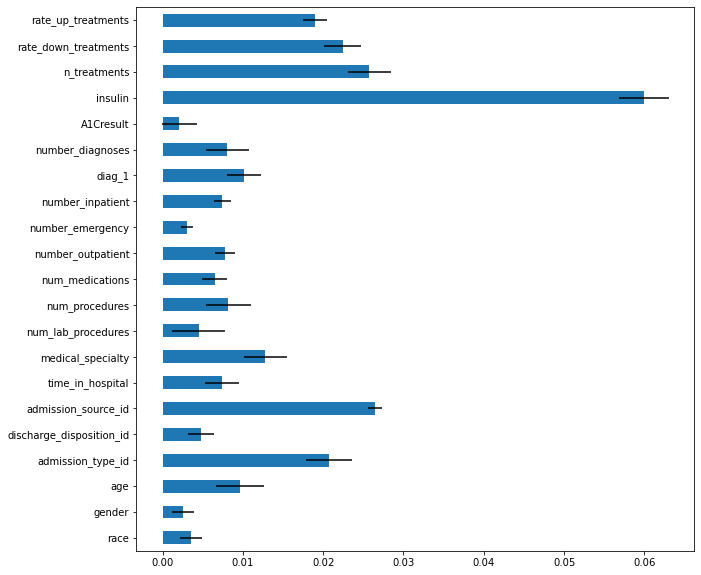

In [72]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42, scoring=f1_weighted_score)
f_importances = pd.Series(result.importances_mean, index=X_test.columns)
plt.figure(figsize=(10, 10)) 
f_importances.plot.barh(xerr=result.importances_std)

Although we expected an improvement in F1 score, we did **not** observe a **significant gain**. However, we noticed that the most relevant features identified by this model differ from those found in other models — particularly variables like insulin, n_treatments, rate_up_treatments, and rate_down_treatments. This suggests that the model may be capturing **different patterns** and interactions among the variables, which could be valuable when combining models in an ensemble approach.

## Ensamble method with majority voting: Logistic regression, Random Forest, AdaBoost

We build a majority voting ensemble using Logistic Regression, Random Forest, and AdaBoost. Each model is inside a pipeline with its own preprocessing and tuned settings. With **hard voting**, the final prediction is based on the majority vote across models.
This could help improve accuracy, makes predictions more robust and may reduce overfitting from individual classifiers, although it becomes extremely hard to interpret.

In [73]:
pipeline.set_params(classifier__C=1e-2)

voting_clf = VotingClassifier(estimators=[('lr', pipeline), ('rf', pipeline_rf), ('svc', pipeline_boost)], voting='hard')
voting_clf.fit(X_resampled, y_resampled)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preproc',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['time_in_hospital',
                                                                                 'num_lab_procedures',
                                                                                 'num_procedures',
                                                                                 'num_medications',
                                                                                 'number_outpatient',
                                                                                 'number_emergency',
                                                                                 'number_inpatient',
                                                                                 'number_diagnoses',
                                                                                 'n_treatments',
                                                                                 'rate_down_treatments',
                                                                                 'rate_up_treatments']),
                                                                               ('cat',
                                                                                OneHotEncod...
                                                                                 'rate_down_treatments',
                                                                                 'rate_up_treatments']),
                                                                               ('cat',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore'),
                                                                                ['race',
                                                                                 'gender',
                                                                                 'age',
                                                                                 'admission_type_id',
                                                                                 'discharge_disposition_id',
                                                                                 'admission_source_id',
                                                                                 'medical_specialty',
                                                                                 'diag_1',
                                                                                 'A1Cresult',
                                                                                 'insulin'])])),
                                              ('classifier',
                                               AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                                  n_estimators=500))]))])

In [ ]:
y_pred = voting_clf.predict(X_test)
print('Hard-Majority voting accuracy', accuracy_score(y_test, y_pred))
print('Hard-Majority voting F1', f1_score(y_test, y_pred, average='weighted'))


Hard-Majority voting accuracy 0.508749416705553
Hard-Majority voting F1 0.5156738610536352


We now switch to **soft voting**, which averages predicted class probabilities from each model. Unlike hard voting, it considers how confident each model is in its predictions.  This can lead to better performance if the models are well-calibrated.  

In [ ]:
voting_clf2 = VotingClassifier(estimators=[('lr', pipeline), ('rf', pipeline_rf), ('svc', pipeline_boost)], voting='soft')
voting_clf2.fit(X_resampled, y_resampled)


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preproc',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['time_in_hospital',
                                                                                 'num_lab_procedures',
                                                                                 'num_procedures',
                                                                                 'num_medications',
                                                                                 'number_outpatient',
                                                                                 'number_emergency',
                                                                                 'number_inpatient',
                                                                                 'number_diagnoses',
                                                                                 'n_treatments',
                                                                                 'rate_down_treatments',
                                                                                 'rate_up_treatments']),
                                                                               ('cat',
                                                                                OneHotEncod...
                                                                                 'rate_down_treatments',
                                                                                 'rate_up_treatments']),
                                                                               ('cat',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore'),
                                                                                ['race',
                                                                                 'gender',
                                                                                 'age',
                                                                                 'admission_type_id',
                                                                                 'discharge_disposition_id',
                                                                                 'admission_source_id',
                                                                                 'medical_specialty',
                                                                                 'diag_1',
                                                                                 'A1Cresult',
                                                                                 'insulin'])])),
                                              ('classifier',
                                               AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                                  n_estimators=500))]))],
                 voting='soft')

In [76]:
y_pred2 = voting_clf2.predict(X_test)
print('Soft-Majority voting accuracy', accuracy_score(y_test, y_pred))
print('Soft-Majority voting F1', f1_score(y_test, y_pred, average='weighted'))

Soft-Majority voting accuracy 0.508749416705553
Soft-Majority voting F1 0.5156738610536352


We actually observe that the F1 scores from both hard voting and soft voting ensemble methods are slightly lower than that of the tuned Random Forest model.
This may be justified by the fact that, although ensemble methods aim to leverage the strengths of multiple models, the individual models included may **not** be **diverse or complementary enough** to significantly enhance performance.
Additionally, if one model consistently outperforms the others, combining it with weaker models can **dilute its predictive power**, leading to marginally worse results.

# Conclusions